# Notebook 02: Análisis Exploratorio de Datos (EDA)

**Objetivo**: Entender la distribución de las variables, identificar valores nulos y outliers.

## Actividades:
1. Cargar datos desde Parquet (Bronze)
2. Calcular estadísticas descriptivas
3. Analizar distribución por departamento
4. Identificar valores faltantes
5. Detectar outliers en valores de contratos


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, when, isnan, isnull, desc,
    regexp_replace, to_timestamp, year, month,
    avg, min as spark_min, max as spark_max, stddev, sum as spark_sum
)
import pandas as pd
import matplotlib.pyplot as plt
import os


In [2]:
spark = (SparkSession.builder
         .appName("SECOP_EDA")
         .master("spark://spark-master:7077")
         .config("spark.executor.memory", "1g")
         .config("spark.executor.cores", "1")
         .getOrCreate())

spark.sparkContext.setLogLevel("WARN")
print("Spark Version:", spark.version)
print("Spark Master:", spark.sparkContext.master)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/14 23:49:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/14 23:49:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark Version: 3.5.0
Spark Master: spark://spark-master:7077


26/02/14 23:49:38 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
parquet_path = "/opt/spark-data/processed/secop_bronze_q4_2025"
print("Cargando datos desde:", parquet_path)

df = spark.read.parquet(parquet_path)

n = df.count()
print(f"Registros cargados: {n:,}")
print(f"Columnas: {len(df.columns)}")


Cargando datos desde: /opt/spark-data/processed/secop_bronze_q4_2025
Registros cargados: 60,000
Columnas: 87


In [5]:
print("\n=== ESQUEMA ===")
df.printSchema()

print("\n=== MUESTRA (10) ===")
df.show(10, truncate=True)



=== ESQUEMA ===
root
 |-- anno_bpin: string (nullable = true)
 |-- c_digo_bpin: string (nullable = true)
 |-- ciudad: string (nullable = true)
 |-- codigo_de_categoria_principal: string (nullable = true)
 |-- codigo_entidad: string (nullable = true)
 |-- codigo_proveedor: string (nullable = true)
 |-- condiciones_de_entrega: string (nullable = true)
 |-- departamento: string (nullable = true)
 |-- descripcion_del_proceso: string (nullable = true)
 |-- descripcion_documentos_tipo: string (nullable = true)
 |-- destino_gasto: string (nullable = true)
 |-- dias_adicionados: string (nullable = true)
 |-- documento_proveedor: string (nullable = true)
 |-- documentos_tipo: string (nullable = true)
 |-- domicilio_representante_legal: string (nullable = true)
 |-- duraci_n_del_contrato: string (nullable = true)
 |-- el_contrato_puede_ser_prorrogado: string (nullable = true)
 |-- entidad_centralizada: string (nullable = true)
 |-- es_grupo: string (nullable = true)
 |-- es_pyme: string (nullab

26/02/14 23:52:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+---------------+-------------+-----------------------------+--------------+----------------+----------------------+--------------------+-----------------------+---------------------------+--------------+----------------+-------------------+---------------+-----------------------------+---------------------+--------------------------------+--------------------+--------+-------+---------------+-----------+---------------+-------------------------+--------------------+----------------------------+-------------------------------------+---------------------+------------------------+--------------------------+------------------------+------------------+----------------------------------+--------------------------+-----------+--------------------+-------------------------+----------------+-------------------------------------+---------------------------------------+------------------------------+--------------------------------+-----------+----------------+--------------------+----

In [6]:
cols_clave = ["departamento", "modalidad_de_contratacion", "tipo_de_contrato",
              "estado_contrato", "valor_del_contrato", "fecha_de_firma"]

cols_presentes = [c for c in cols_clave if c in df.columns]
print("Columnas clave presentes:", cols_presentes)

df.select(cols_presentes).describe().show()


Columnas clave presentes: ['departamento', 'modalidad_de_contratacion', 'tipo_de_contrato', 'estado_contrato', 'valor_del_contrato', 'fecha_de_firma']


+-------+------------+-------------------------+--------------------+---------------+--------------------+--------------------+
|summary|departamento|modalidad_de_contratacion|    tipo_de_contrato|estado_contrato|  valor_del_contrato|      fecha_de_firma|
+-------+------------+-------------------------+--------------------+---------------+--------------------+--------------------+
|  count|       60000|                    60000|               60000|          60000|               60000|               60000|
|   mean|        NULL|                     NULL|                NULL|           NULL|1.6052876166601667E8|                NULL|
| stddev|        NULL|                     NULL|                NULL|           NULL| 2.626710457599387E9|                NULL|
|    min|    Amazonas|     Concurso de mérit...|Arrendamiento de ...|       Aprobado|                   0|2025-10-01T00:00:...|
|    max|     Vichada|     Selección abrevia...|       Venta muebles|      terminado|           99999996

In [8]:
print("\n=== NULOS POR COLUMNA ===")

dtypes = dict(df.dtypes)  # {"col": "string", "col2": "struct<...>", ...}

exprs = []
for c in df.columns:
    t = dtypes[c]
    if t in ("double", "float"):
        exprs.append(count(when(isnull(col(c)) | isnan(col(c)), c)).alias(c))
    else:
        exprs.append(count(when(isnull(col(c)), c)).alias(c))

null_counts = df.select(exprs)

null_df = null_counts.toPandas().T
null_df.columns = ["null_count"]
null_df["null_percentage"] = (null_df["null_count"] / n) * 100
null_df = null_df.sort_values("null_count", ascending=False)

display(null_df[null_df["null_count"] > 0].head(25))



=== NULOS POR COLUMNA ===


,null_count,null_percentage
fecha_de_notificaci_n_de_prorrogaci_n,56505,94.175000
fecha_fin_liquidacion,51534,85.890000
fecha_inicio_liquidacion,51534,85.890000
ultima_actualizacion,41869,69.781667
fecha_de_inicio_del_contrato,875,1.458333


## Análisis de valores nulos

En el análisis de valores faltantes del trimestre Q4 2025 (60.000 registros), se identificó que algunas variables presentan un porcentaje alto de datos nulos. Sin embargo, al revisar su significado dentro del proceso contractual, se observa que estos valores no necesariamente indican errores en la base de datos, sino que responden a condiciones específicas del ciclo de vida del contrato.

Por ejemplo, la variable `fecha_de_notificacion_de_prorroga` presenta aproximadamente un 94% de valores nulos. Esto es consistente con el hecho de que no todos los contratos son prorrogados, por lo tanto, la ausencia de información en esta columna es esperable desde el punto de vista del negocio. De manera similar, `fecha_fin_liquidacion` y `fecha_inicio_liquidacion` tienen cerca del 86% de valores nulos, lo cual se explica porque muchos contratos aún no han sido liquidados o no requieren este proceso.

Por otro lado, variables clave como `fecha_de_inicio_del_contrato` presentan un porcentaje muy bajo de valores faltantes (alrededor del 1.45%), lo que indica una buena calidad en los datos esenciales para el análisis temporal. En general, las variables fundamentales para el estudio del valor y estado del contrato no presentan problemas significativos de completitud.

En conclusión, los valores nulos detectados están mayormente asociados a características condicionales del contrato y no a fallas en la recolección de información. Desde una perspectiva estadística, el dataset es consistente y adecuado para continuar con el análisis exploratorio y etapas posteriores de modelado.


In [11]:
# Limpieza numérica (quita símbolos, espacios, letras) y maneja coma/punto
df_eda = (df
          .withColumn("valor_del_contrato_clean",
                      regexp_replace(col("valor_del_contrato"), r"[^0-9,\.]", ""))
          .withColumn("valor_del_contrato_num",
                      regexp_replace(col("valor_del_contrato_clean"), ",", ".").cast("double"))
          .withColumn("fecha_de_firma_ts",
            to_timestamp(col("fecha_de_firma"), "yyyy-MM-dd'T'HH:mm:ss.SSS"))
          .withColumn("anio_firma", year(col("fecha_de_firma_ts")))
          .withColumn("mes_firma", month(col("fecha_de_firma_ts")))
)

df_eda.select("valor_del_contrato", "valor_del_contrato_num", "fecha_de_firma", "fecha_de_firma_ts").show(5, truncate=False)


+------------------+----------------------+-----------------------+-------------------+
|valor_del_contrato|valor_del_contrato_num|fecha_de_firma         |fecha_de_firma_ts  |
+------------------+----------------------+-----------------------+-------------------+
|10578876          |1.0578876E7           |2025-10-09T00:00:00.000|2025-10-09 00:00:00|
|15400000          |1.54E7                |2025-10-09T00:00:00.000|2025-10-09 00:00:00|
|3356160           |3356160.0             |2025-10-09T00:00:00.000|2025-10-09 00:00:00|
|219732526         |2.19732526E8          |2025-10-09T00:00:00.000|2025-10-09 00:00:00|
|6300000           |6300000.0             |2025-10-09T00:00:00.000|2025-10-09 00:00:00|
+------------------+----------------------+-----------------------+-------------------+
only showing top 5 rows



In [12]:
print("\n=== ESTADÍSTICAS: valor_del_contrato_num ===")

df_eda.select(
    spark_min(col("valor_del_contrato_num")).alias("Min"),
    spark_max(col("valor_del_contrato_num")).alias("Max"),
    avg(col("valor_del_contrato_num")).alias("Promedio"),
    stddev(col("valor_del_contrato_num")).alias("Desv_Std")
).show()




=== ESTADÍSTICAS: valor_del_contrato_num ===


+---+----------------+--------------------+-------------------+
|Min|             Max|            Promedio|           Desv_Std|
+---+----------------+--------------------+-------------------+
|0.0|2.96539017355E11|1.6052876166601667E8|2.626710457599387E9|
+---+----------------+--------------------+-------------------+



In [13]:
df_eda.select(
    count(when(col("valor_del_contrato_num") < 10000000, True)).alias("< 10M"),
    count(when((col("valor_del_contrato_num") >= 10000000) & 
               (col("valor_del_contrato_num") < 100000000), True)).alias("10M-100M"),
    count(when((col("valor_del_contrato_num") >= 100000000) & 
               (col("valor_del_contrato_num") < 1000000000), True)).alias("100M-1B"),
    count(when(col("valor_del_contrato_num") >= 1000000000, True)).alias("> 1B")
).show()


+-----+--------+-------+----+
|< 10M|10M-100M|100M-1B|> 1B|
+-----+--------+-------+----+
|24044|   30452|   4327|1177|
+-----+--------+-------+----+



## Análisis de la Distribución del Valor de los Contratos

La mayoría de los contratos se concentra en rangos bajos y medios, especialmente entre 10 y 100 millones de pesos, seguido por aquellos menores a 10 millones. Esto indica que la contratación pública en el trimestre analizado está compuesta principalmente por contratos de pequeña y mediana cuantía.

Los contratos superiores a 100 millones, y especialmente los mayores a 1.000 millones, representan una proporción mucho menor del total. Sin embargo, estos valores altos influyen significativamente en el promedio, generando una distribución asimétrica positiva (sesgada a la derecha).

En términos estadísticos, esto sugiere la presencia de valores extremos que elevan la media, por lo que medidas como la mediana y el análisis por percentiles pueden ser más representativas del comportamiento real de la variable.


In [14]:
print("\n=== TOP 10 DEPARTAMENTOS ===")

df_dept = (df_eda.groupBy("departamento")
           .agg(
               count("*").alias("num_contratos"),
               spark_sum(col("valor_del_contrato_num")).alias("valor_total")
           )
           .orderBy(desc("num_contratos"))
           .limit(10))

df_dept.show(truncate=False)

df_dept_pd = df_dept.toPandas()



=== TOP 10 DEPARTAMENTOS ===


+--------------------------+-------------+-----------------+
|departamento              |num_contratos|valor_total      |
+--------------------------+-------------+-----------------+
|Distrito Capital de Bogotá|17758        |2.747843578709E12|
|Antioquia                 |5295         |2.393881024048E12|
|Valle del Cauca           |4963         |4.85491502347E11 |
|Santander                 |3097         |2.53826660987E11 |
|Magdalena                 |2703         |5.9185034277E10  |
|Cundinamarca              |2446         |6.55081047929E11 |
|Atlántico                 |2211         |1.86769495881E11 |
|Bolívar                   |2172         |2.32167137413E11 |
|Norte de Santander        |1996         |2.18493425553E11 |
|Meta                      |1721         |1.31278677087E11 |
+--------------------------+-------------+-----------------+



Gráfico guardado: /opt/spark-data/processed/eda/eda_top_departamentos_conteo.png


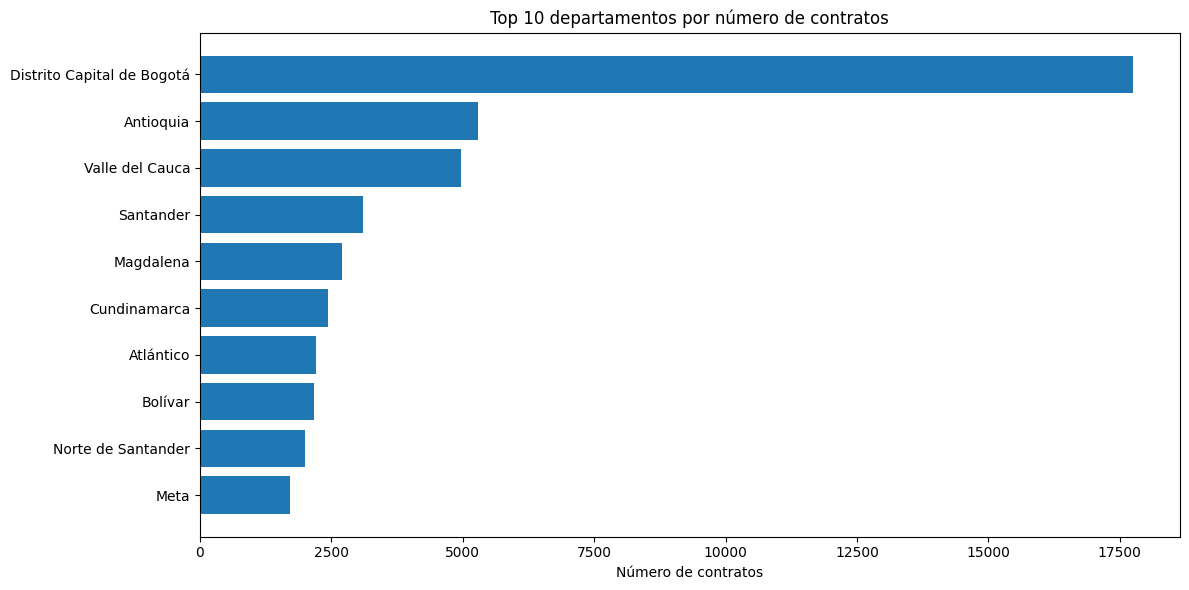

In [15]:
out_dir = "/opt/spark-data/processed/eda"
os.makedirs(out_dir, exist_ok=True)

plt.figure(figsize=(12, 6))
plt.barh(df_dept_pd["departamento"], df_dept_pd["num_contratos"])
plt.xlabel("Número de contratos")
plt.title("Top 10 departamentos por número de contratos")
plt.gca().invert_yaxis()
plt.tight_layout()

png_path = os.path.join(out_dir, "eda_top_departamentos_conteo.png")
plt.savefig(png_path, dpi=150, bbox_inches="tight")
print("Gráfico guardado:", png_path)


In [16]:
print("\n=== DISTRIBUCIÓN POR ESTADO_CONTRATO ===")

df_estado = (df_eda.groupBy("estado_contrato")
             .agg(count("*").alias("num_contratos"))
             .orderBy(desc("num_contratos")))

df_estado.show(20, truncate=False)



=== DISTRIBUCIÓN POR ESTADO_CONTRATO ===
+---------------+-------------+
|estado_contrato|num_contratos|
+---------------+-------------+
|En ejecución   |41065        |
|Modificado     |13455        |
|terminado      |2946         |
|Cerrado        |1150         |
|Aprobado       |890          |
|Suspendido     |310          |
|cedido         |183          |
|Cancelado      |1            |
+---------------+-------------+



In [17]:
print("\n=== DISTRIBUCIÓN POR TIPO_DE_CONTRATO ===")

df_tipo = (df_eda.groupBy("tipo_de_contrato")
           .agg(count("*").alias("num_contratos"))
           .orderBy(desc("num_contratos"))
           .limit(20))

df_tipo.show(truncate=False)



=== DISTRIBUCIÓN POR TIPO_DE_CONTRATO ===
+------------------------------+-------------+
|tipo_de_contrato              |num_contratos|
+------------------------------+-------------+
|Prestación de servicios       |48552        |
|Decreto 092 de 2017           |3570         |
|Otro                          |2965         |
|Suministros                   |1661         |
|Compraventa                   |1394         |
|Obra                          |937          |
|Arrendamiento de inmuebles    |287          |
|Consultoría                   |195          |
|Interventoría                 |154          |
|Comodato                      |124          |
|Seguros                       |102          |
|Servicios financieros         |18           |
|Arrendamiento de muebles      |16           |
|Operaciones de Crédito Público|11           |
|Venta muebles                 |6            |
|Asociación Público Privada    |5            |
|Concesión                     |3            |
+----------------

In [18]:
print("\n=== OUTLIERS (IQR) ===")

# Filtra nulos para que no afecten cuantiles
df_val = df_eda.filter(col("valor_del_contrato_num").isNotNull())

percentiles = df_val.approxQuantile("valor_del_contrato_num", [0.25, 0.50, 0.75, 0.95, 0.99], 0.01)
q1, q2, q3, p95, p99 = percentiles

iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Q1:  {q1:,.2f}")
print(f"Q2:  {q2:,.2f}")
print(f"Q3:  {q3:,.2f}")
print(f"P95: {p95:,.2f}")
print(f"P99: {p99:,.2f}")
print(f"\nRango normal (IQR): {lower_bound:,.2f}  -  {upper_bound:,.2f}")

num_outliers = df_val.filter(
    (col("valor_del_contrato_num") < lower_bound) | (col("valor_del_contrato_num") > upper_bound)
).count()

total_validos = df_val.count()
print(f"Outliers: {num_outliers:,} / {total_validos:,}  ({(num_outliers/total_validos)*100:.2f}%)")



=== OUTLIERS (IQR) ===


Q1:  7,200,000.00
Q2:  12,000,000.00
Q3:  25,179,039.00
P95: 216,957,155.00
P99: 296,539,017,355.00

Rango normal (IQR): -19,768,558.50  -  52,147,597.50
Outliers: 8,416 / 60,000  (14.03%)


In [19]:
print("\n" + "="*60)
print("RESUMEN EDA")
print("="*60)
print(f"✓ Registros analizados: {n:,}")
print(f"✓ Columnas: {len(df.columns)}")

total_valor = df_eda.select(spark_sum(col("valor_del_contrato_num"))).collect()[0][0]
if total_valor is not None:
    print(f"✓ Valor total (COP): {total_valor:,.2f}")

print(f"✓ Outliers detectados: {num_outliers:,}")
print(f"✓ Gráficos: {out_dir}")
print("="*60)



RESUMEN EDA
✓ Registros analizados: 60,000
✓ Columnas: 87
✓ Valor total (COP): 9,631,725,699,961.00
✓ Outliers detectados: 8,416
✓ Gráficos: /opt/spark-data/processed/eda


In [20]:
output_path = "/opt/spark-data/processed/secop_eda_q4_2025.parquet"

(df_eda.write
 .mode("overwrite")
 .parquet(output_path))

print("Dataset EDA guardado en:", output_path)


26/02/15 00:36:02 ERROR TaskSchedulerImpl: Lost executor 1 on 172.20.0.5: Command exited with code 137
26/02/15 00:36:02 WARN TaskSetManager: Lost task 1.0 in stage 48.0 (TID 50) (172.20.0.5 executor 1): ExecutorLostFailure (executor 1 exited caused by one of the running tasks) Reason: Command exited with code 137


Dataset EDA guardado en: /opt/spark-data/processed/secop_eda_q4_2025.parquet


In [21]:
spark.stop()
print("SparkSession finalizada")


SparkSession finalizada
